# A Network Tour of Data Science, EPFL 2016
# Project: Facial Emotion Recognition
students: Patryk Oleniuk, Carmen Galotta



The project presented here is an algorithm to recognize and detect emotions from a face picture. 

Of course, the task of recognize face emotions is very easy for humans to do even if somethimes is really hard to understand how a person feels, but what can be easily understood thanks to human's brain, is difficult to emulate by a machine.

The aim of this project is to classify faces in discrete human emotions. Due to the success of Neural Network in images classification tasks it has been tought that employing it could  be a good idea in also face emotion.

The dataset has been taken from the kaggle competition and consists of 48x48 grey images already labeled with a number coding for 7 classes of emotions, namely: 

0-Angry<br>
1-Disgust<br>
2-Fear<br>
3-Happy<br>
4-Sad<br>
5-Surprise<br>
6-Neutral<br>

The faces are mostly centered in the image.

In [2]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc
import time
import collections
import os
import utils as ut
import importlib

importlib.reload(ut)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Data Visualization
# Load the shortened raw CSV data, it contains only 300 pictures with labels
emotions_dataset_dir = 'fer2013_shortened.csv'

#obtaining the number of line of the csv file
file = open(emotions_dataset_dir)
numline = len(file.readlines())
print (numline)


1200


# Load the data from *.csv file 
The first step was to load the data from the .csv file. <br> The  format of the csv line is<br>
class{0,1,2,3,4,5,6},pix0 pix2304,DataUsage(not used)<br>
e.g.<br>
2,234 1 34 23 ..... 234 256 0,Training<br>
The picture is always 48x48 pixels, 0-255 greyscale.
# Remove crappy data
In the database there are some images thar are not good (e.g. some images are pixelated, unrelevant, from animations).
It has been tried to filter them by looking at the maximum of the histogram. If the image is very homogenous, the maximum value of the histogram will be very high (that is to say above a certain threshold) then this image is filtered out. Of course in this way are also removed some relevant information, but it's better for the CNN not to consider these images.

In [3]:
#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

#preparing labels(Y) and images(X) data vectors
rownum = 0
num_data = numline;

#preparing arrays
emotions = np.zeros(num_data)
images = np.zeros((num_data,48,48))
strange_im = np.zeros((num_data,48,48))

# for image pre-filtering
num_strange = 0; #number of removed images
hist_threshold = 270 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

#parsing each row
for row in reader:
    #(column0) extract the emotion label
    #!!!! convert 1 and 0 together !!!!
    if( (row[0] == '0') or (row[0] == '1' ) ):
        emotions[rownum] = '0';
    else :
        emotions[rownum] = str(int(row[0])-1)

    #(column1) extract the image data, parse it and convert into 48x48 array of integers
    images[rownum] = np.asarray([int(s) for s in row[1].split(' ')]).reshape(48,48)
    
    #stretching contrast of the image
    images[rownum] = ut.contrast_stretch(images[rownum])
    
    #calculating the histogram and erasing "strange" images
    y_h, x_h = np.histogram( images[ rownum ] , 100 );
    if y_h.max() > hist_threshold  : 
        # if img is 'strange'
        strange_im[num_strange,:,:] = images[rownum,:,:]
        num_data = num_data - 1;
        images = np.delete(images, rownum, axis = 0);
        emotions = np.delete(emotions, rownum)
        #print('deleted:' + str(rownum))
        num_strange += 1;   
    else:
        rownum += 1
    if not rownum%200:
        print("loaded %2.0f" % ((float(rownum ) /num_data)*100) 
              + '% of dataset('+ str(rownum+num_strange)+'/'+ str(numline) + '). Filtered images: ' + str(num_strange) )
ifile.close()

print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')

# showing strange images
#for i in range(0,int(num_strange)):
#    plt.subplot( int(np.ceil(num_strange/5)),5,  i+1)
#    plt.imshow(strange_im[i])
#    y_h, x_h = np.histogram( strange_im[i,:,:] ,hist_div);
#    strange_im.sort(axis=0, )
#    plt.axis('off')
#    plt.title('max(hist) = ' + str(y_h.max()))

loaded 17% of dataset(221/1200). Filtered images: 21
loaded 34% of dataset(435/1200). Filtered images: 35
loaded 52% of dataset(655/1200). Filtered images: 55
loaded 71% of dataset(869/1200). Filtered images: 69
loaded 90% of dataset(1089/1200). Filtered images: 89
1108 are left after 'strange images' removal.
Deleted 92 strange images. Images are shown below


# Explore the data
Plot some random pictures from each class.

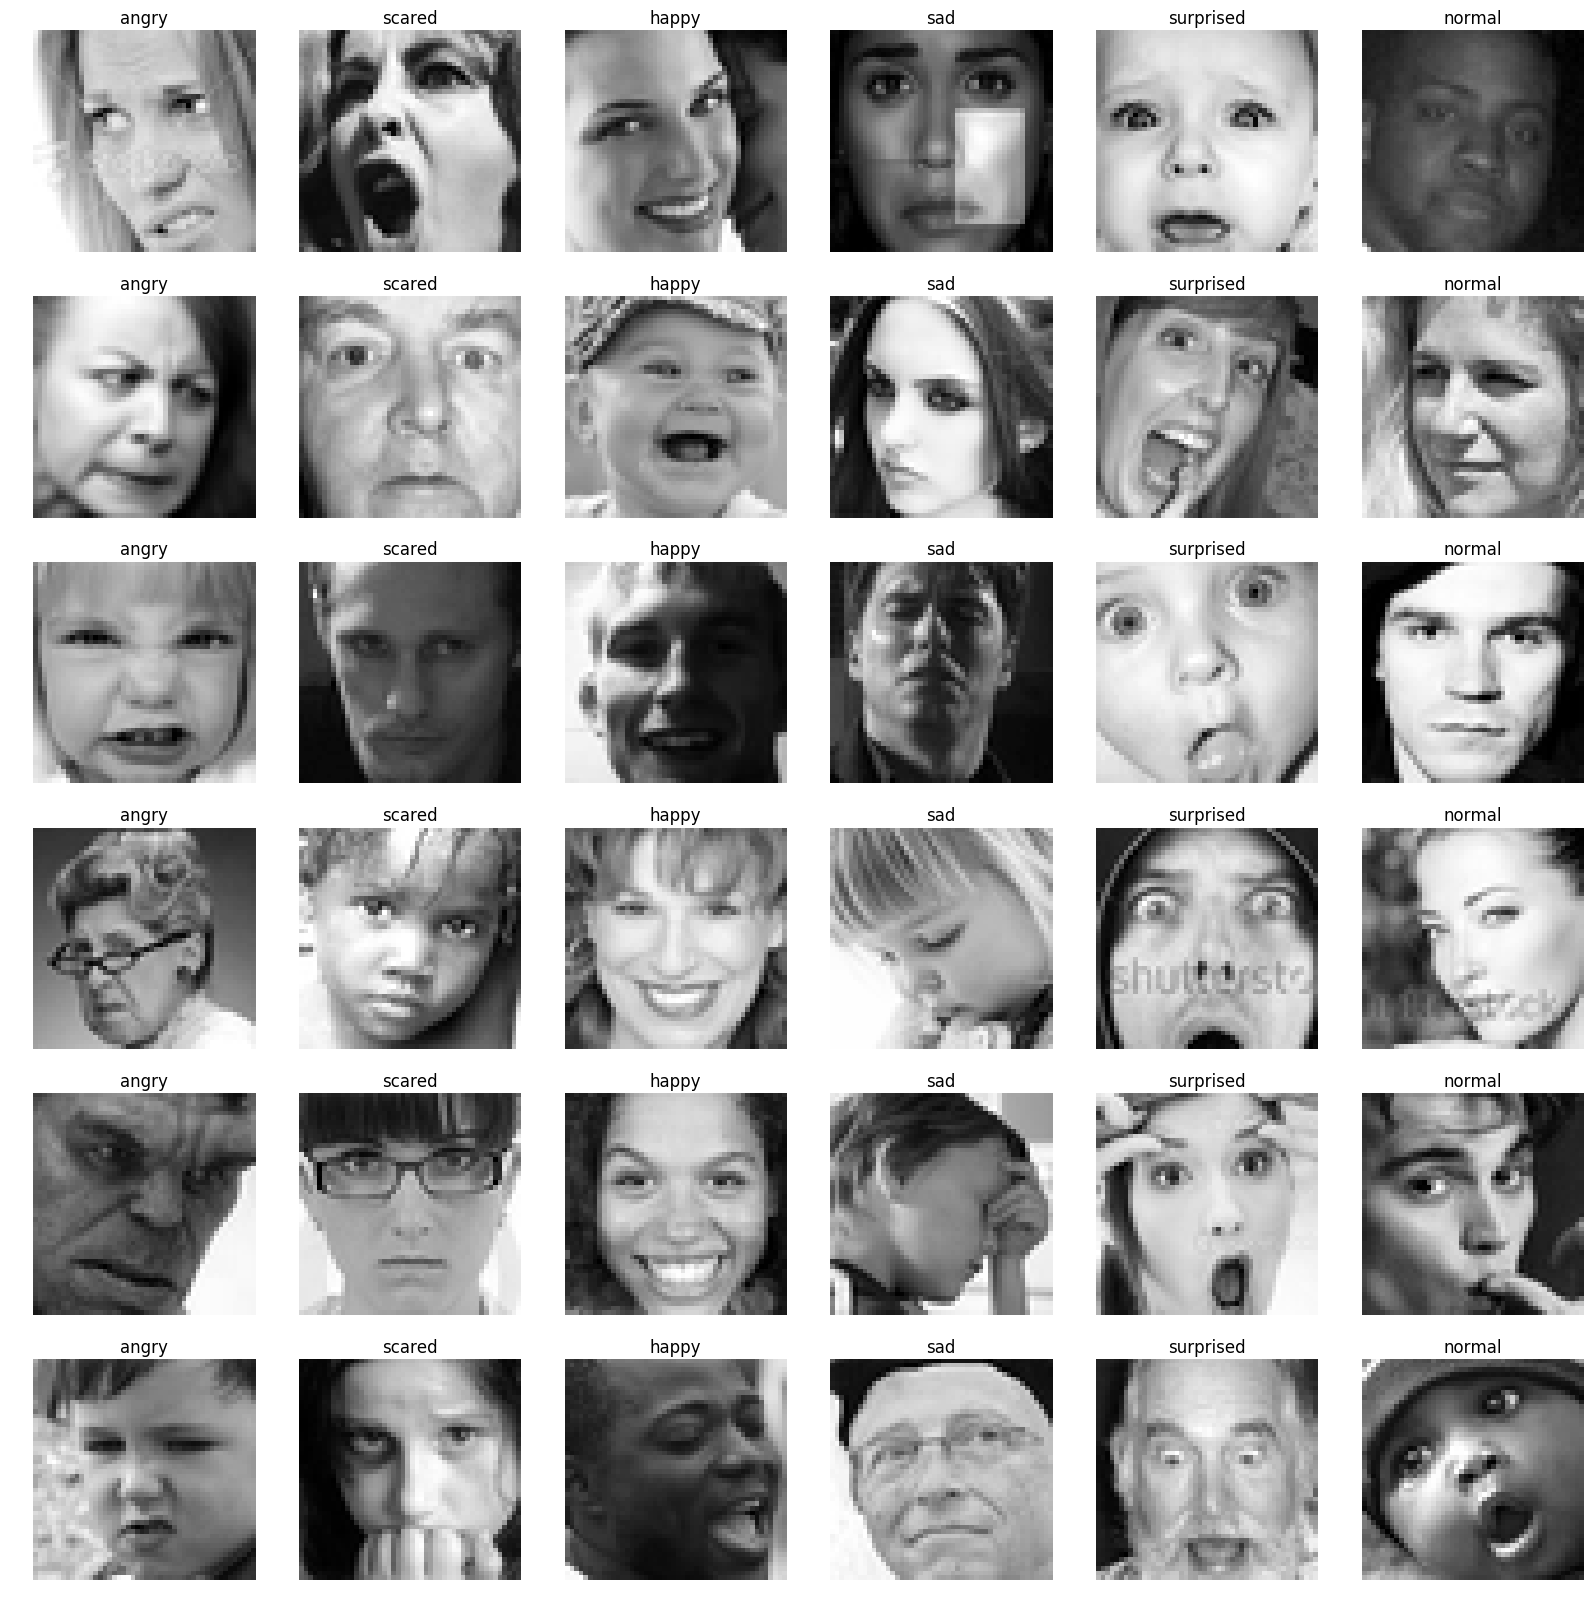

In [4]:
classes = [0,1,2,3,4,5]
str_emotions = ['angry','scared','happy','sad','surprised','normal']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(emotions == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx])
        y_h, x_h = np.histogram( images[idx], hist_div );
        plt.axis('off')
        plt.title(str_emotions[y] )
plt.show()

# Prepare the Data for CNN
Here the initial data have been divided to create train and test data. <bv>
This two subsets have both an associated label to train the neural network and to test its accuracy with the test data.
The number of images used for each category of emotions is shown both for the train as for the test data.

In [35]:
print('number of clean data:' + str(images.shape[0]) + '  48x48 pix , 0-255 greyscale images')
n_all = images.shape[0];
n_train = 64; # number of data for training and for batch

# dividing the input data
train_data_orig = images[0:n_all-n_train,:,:]
train_labels = emotions[0:n_all-n_train]
test_data_orig = images[n_all-n_train:n_all,:,:]
test_labels = emotions[n_all-n_train:n_all]

# Convert to float
train_data_orig = train_data_orig.astype('float32')
y_train = train_labels.astype('float32')
test_data_orig = test_data_orig.astype('float32')
y_test = test_labels.astype('float32')

print('orig train data ' + str(train_data_orig.shape))
print('orig train labels ' + str(train_labels.shape) + 'from ' + str(train_labels.min()) + ' to ' + str(train_labels.max()) )
print('orig test data ' + str(test_data_orig.shape))
print('orig test labels ' + str(test_labels.shape)+ 'from ' + str(test_labels.min()) + ' to ' + str(test_labels.max()) )
print('TRAIN: number of 0 labels',len(train_labels[train_labels == 0]))
print('TRAIN: number of 1 labels',len(train_labels[train_labels == 1]))
print('TRAIN: number of 2 labels',len(train_labels[train_labels == 2]))
print('TRAIN: number of 3 labels',len(train_labels[train_labels == 3]))
print('TRAIN: number of 4 labels',len(train_labels[train_labels == 4]))
print('TRAIN: number of 5 labels',len(train_labels[train_labels == 5]))
print('TEST: number of 0 labels',len(test_labels[test_labels == 0]))
print('TEST: number of 1 labels',len(test_labels[test_labels == 1]))
print('TEST: number of 2 labels',len(test_labels[test_labels == 2]))
print('TEST: number of 3 labels',len(test_labels[test_labels == 3]))
print('TEST: number of 4 labels',len(test_labels[test_labels == 4]))
print('TEST: number of 5 labels',len(test_labels[test_labels== 5]))
#plt.imshow(train_data_orig[0,:,:])

number of clean data:1108  48x48 pix , 0-255 greyscale images
orig train data (1044, 48, 48)
orig train labels (1044,)from 0.0 to 5.0
orig test data (64, 48, 48)
orig test labels (64,)from 0.0 to 5.0
TRAIN: number of 0 labels 186
TRAIN: number of 1 labels 146
TRAIN: number of 2 labels 271
TRAIN: number of 3 labels 172
TRAIN: number of 4 labels 103
TRAIN: number of 5 labels 166
TEST: number of 0 labels 13
TEST: number of 1 labels 9
TEST: number of 2 labels 13
TEST: number of 3 labels 14
TEST: number of 4 labels 6
TEST: number of 5 labels 9


# Convert, normalize, subtract the const mean value from the data


In [36]:
# Data pre-processing
n = train_data_orig.shape[0];
train_data = np.zeros([n,48**2])
for i in range(n):
    xx = train_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,48**2])
for i in range(n):
    xx = test_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print(train_data.shape)
print(test_data.shape)
print(train_data_orig[0][2][2])
print(test_data[0][2])
#plt.imshow(train_data[0].reshape([48,48]))

(1044, 2304)
(64, 2304)
-0.026113
-0.0591093041003


In [37]:
# Convert label values to one_hot vector

train_labels = ut.convert_to_one_hot(train_labels,num_classes)
test_labels = ut.convert_to_one_hot(test_labels,num_classes)

print(train_labels.shape)
print(test_labels.shape)

(1044, 6)
(64, 6)


# Model 

In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is simply:


$$
y=\textrm{softmax}(ReLU( x \ast W_1+b_1)W_2+b_2) 
$$


In [8]:
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)

In [42]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 10   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0
Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
#bcl0 = tf.Variable(tf.zeros([F0])); print('bcl=',bcl0.get_shape())
bcl0 = bias_variable([F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())
x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
x += bcl0; print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
#x = tf.nn.dropout(x, 0.25)

# Fully Connected layer
nfc = 48*48*F0
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Wcl= (10, 10, 1, 64)
bcl0= (64,)
x_2d= (64, 48, 48, 1)
x2= (64, 48, 48, 64)
x3= (64, 147456)
Wfc= (147456, 6)
bfc= (6,)
y1= (64, 6)
y2= (64, 6)
y3(SOFTMAX)= (64, 6)


# Runing the computational graph

In [43]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.171875 , loss= 1.7911
test accuracy= 0.203125

Iteration i= 50 , train accuracy= 0.296875 , loss= 1.62821
test accuracy= 0.1875

Iteration i= 100 , train accuracy= 0.578125 , loss= 1.14282
test accuracy= 0.3125

Iteration i= 150 , train accuracy= 0.6875 , loss= 0.906755
test accuracy= 0.28125

Iteration i= 200 , train accuracy= 0.71875 , loss= 0.733014
test accuracy= 0.3125

Iteration i= 250 , train accuracy= 0.8125 , loss= 0.550771
test accuracy= 0.34375

Iteration i= 300 , train accuracy= 0.953125 , loss= 0.297246
test accuracy= 0.296875

Iteration i= 350 , train accuracy= 0.9375 , loss= 0.264587
test accuracy= 0.34375

Iteration i= 400 , train accuracy= 1.0 , loss= 0.119752
test accuracy= 0.265625

Iteration i= 450 , train accuracy= 1.0 , loss= 0.0723346
test accuracy= 0.25

Iteration i= 500 , train accuracy= 1.0 , loss= 0.0651125
test accuracy= 0.28125

Iteration i= 550 , train accuracy= 1.0 , loss= 0.0368162
test accuracy= 0.296875

Iteration i=

As it is possible to see from this result, the model overfits the training data already at iteration 400, while getting a test accuracy of only 28%.
In order to prevent overfitting in the following model have been applied different techniques such as dropout and pool, as well as tried to implement a neural network of more layers. 

This should help and improve the model since the first convolutional layer will just extract some simplest characteristics of the image such as edges, lines and curves. Adding layers will improve the performances because they will detect some high level feature which in this case could be really relevant since it's about face expressions.

https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/

# Choosing Hyperparameters

How do we know how many layers to use, how many conv layers, what are the filter sizes, or the values for stride and padding? These are not trivial questions and there isn’t a set standard that is used by all researchers. This is because the network will largely depend on the type of data that you have. Data can vary by size, complexity of the image, type of image processing task, and more. When looking at your dataset, one way to think about how to choose the hyperparameters is to find the right combination that creates abstractions of the image at a proper scale.

# ReLU (Rectified Linear Units) Layers
After each conv layer, it is convention to apply a nonlinear layer (or activation layer) immediately afterward.The purpose of this layer is to introduce nonlinearity to a system that basically has just been computing linear operations during the conv layers (just element wise multiplications and summations).In the past, nonlinear functions like tanh and sigmoid were used, but researchers found out that ReLU layers work far better because the network is able to train a lot faster (because of the computational efficiency) without making a significant difference to the accuracy. It also helps to alleviate the vanishing gradient problem, which is the issue where the lower layers of the network train very slowly because the gradient decreases exponentially through the layers (Explaining this might be out of the scope of this post, but see here and here for good descriptions). The ReLU layer applies the function f(x) = max(0, x) to all of the values in the input volume. In basic terms, this layer just changes all the negative activations to 0.This layer increases the nonlinear properties of the model and the overall network without affecting the receptive fields of the conv layer.

Paper by the great Geoffrey Hinton (aka the father of deep learning).

# Pooling Layers


After some ReLU layers, programmers may choose to apply a pooling layer. It is also referred to as a downsampling layer. In this category, there are also several layer options, with maxpooling being the most popular. This basically takes a filter (normally of size 2x2) and a stride of the same length. It then applies it to the input volume and outputs the maximum number in every subregion that the filter convolves around.

Other options for pooling layers are average pooling and L2-norm pooling. The intuitive reasoning behind this layer is that once we know that a specific feature is in the original input volume (there will be a high activation value), its exact location is not as important as its relative location to the other features. As you can imagine, this layer drastically reduces the spatial dimension (the length and the width change but not the depth) of the input volume. This serves two main purposes. The first is that the amount of parameters or weights is reduced by 75%, thus lessening the computation cost. The second is that it will control overfitting. This term refers to when a model is so tuned to the training examples that it is not able to generalize well for the validation and test sets. A symptom of overfitting is having a model that gets 100% or 99% on the training set, but only 50% on the test data.

# Dropout Layers


Now, dropout layers have a very specific function in neural networks. In the last section, we discussed the problem of overfitting, where after training, the weights of the network are so tuned to the training examples they are given that the network doesn’t perform well when given new examples. The idea of dropout is simplistic in nature. This layer “drops out” a random set of activations in that layer by setting them to zero in the forward pass. Simple as that. Now, what are the benefits of such a simple and seemingly unnecessary and counterintuitive process? Well, in a way, it forces the network to be redundant. By that I mean the network should be able to provide the right classification or output for a specific example even if some of the activations are dropped out. It makes sure that the network isn’t getting too “fitted” to the training data and thus helps alleviate the overfitting problem. An important note is that this layer is only used during training, and not during test time.

Paper by Geoffrey Hinton.

# Model 2

The difference from model 1 is that the size of the filter has been decreased to 5 (i'm changing it to 10) and it has been applied a dropout technique to prevent overfitting.

In [46]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 5   # size of the patch
F0 = 10  # number of filters
ncl0 = K0*K0*F0
Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
#bcl0 = tf.Variable(tf.zeros([F0])); print('bcl=',bcl0.get_shape())
bcl0 = bias_variable([F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())
x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
x += bcl0; print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
x = tf.nn.dropout(x, 0.25)

# Fully Connected layer
nfc = 48*48*F0
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Wcl= (5, 5, 1, 10)
bcl0= (10,)
x_2d= (64, 48, 48, 1)
x2= (64, 48, 48, 10)
x3= (64, 23040)
Wfc= (23040, 6)
bfc= (6,)
y1= (64, 6)
y2= (64, 6)
y3(SOFTMAX)= (64, 6)


In [47]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(10001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%1000:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.15625 , loss= 1.78885
test accuracy= 0.21875

Iteration i= 1000 , train accuracy= 0.828125 , loss= 0.616362
test accuracy= 0.234375

Iteration i= 2000 , train accuracy= 0.84375 , loss= 0.38766
test accuracy= 0.296875

Iteration i= 3000 , train accuracy= 0.90625 , loss= 0.343264
test accuracy= 0.328125

Iteration i= 4000 , train accuracy= 0.953125 , loss= 0.17223
test accuracy= 0.21875

Iteration i= 5000 , train accuracy= 0.96875 , loss= 0.073683
test accuracy= 0.234375

Iteration i= 6000 , train accuracy= 0.953125 , loss= 0.0869235
test accuracy= 0.21875

Iteration i= 7000 , train accuracy= 0.984375 , loss= 0.0683548
test accuracy= 0.296875

Iteration i= 8000 , train accuracy= 1.0 , loss= 0.0803793
test accuracy= 0.28125

Iteration i= 9000 , train accuracy= 0.96875 , loss= 0.0715012
test accuracy= 0.3125

Iteration i= 10000 , train accuracy= 1.0 , loss= 0.00932471
test accuracy= 0.296875


Comments: as it can be seen, the performances improved a little bit but the test accuracy is still too low.

# Model 3 

For the reason aforementioned it has been decided to try with a different approach in order to have the trained neural network more efficient for the test data and thus for the new unknown data that it will receive. 
To do so, a more complex model has been tought and implemented, composed of 10 layers.
And also, a drop out as well as pool techniques have been added to the network.

The equation is approximately this (check):
$$
y=\textrm{softmax}(ReLU( x_{in} \ast W_1+b_1) \ast W_2+b_2) 
$$


In [38]:
d = train_data.shape[1] 
#Défining network
def weight_variable2(shape):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)
#def bias_variable(shape):
#        initial=tf.random_normal(0.05,shape=shape)
#        return tf.Variable(initial)

def conv2dstride2(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 2, 2, 1], padding='SAME')

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        return tf.Variable(initial)


In [52]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 5   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0
F1=2*F0 #K=3,F=96, F1=192 = 2*F0
nfc = 48*48*F0
keep_prob_input=tf.placeholder(tf.float32)
keep_prob_pool=tf.placeholder(tf.float32)


#First set of conv followed by conv stride 2 operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d0=',x_2d0.get_shape())

#x_dropped=tf.nn.dropout(x_2d0,keep_prob_input); print('x_dropped=',x_dropped.get_shape())
h_conv1=tf.nn.relu(conv2d(x_2d0,W_conv1)+b_conv1); print('h_conv1=',h_conv1.get_shape())
#h_conv1=tf.reshape(h_conv1, [-1,48,48,1]);
# 2nd convolutional layer layer 
W_conv2=weight_variable([3,3,64,64]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([64]); print('b_conv2=',b_conv2.get_shape())

h_conv2=tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())

#h_conv3=tf.nn.avg_pool(h_conv2,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'); print('h_conv3=',h_conv3.get_shape());

x = tf.nn.dropout(h_conv2, 0.2)

x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([ 147456,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

## Softmax
y = tf.nn.softmax(y); print('y3_{SOFTMAX}=',y.get_shape())


#regularization 
#reg_par=1*1e-6
#reg_loss=0
#reg_loss+=tf.nn.l2_loss(W_conv1)
#reg_loss+=tf.nn.l2_loss(b_conv1)
#reg_loss+=tf.nn.l2_loss(W_conv2)
#reg_loss+=tf.nn.l2_loss(b_conv2)
#reg_loss+=tf.nn.l2_loss(Wfc)
#reg_loss+=tf.nn.l2_loss(bfc)

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy # + reg_par*reg_loss

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.2).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


W_conv1= (5, 5, 1, 64)
b_conv1= (64,)
x_2d0= (64, 48, 48, 1)
h_conv1= (64, 48, 48, 64)
W_conv2= (3, 3, 64, 64)
b_conv2= (64,)
h_conv2= (64, 48, 48, 64)
x3= (64, 147456)
Wfc= (147456, 6)
bfc= (6,)
y1= (64, 6)
y2= (64, 6)
y3_{SOFTMAX}= (64, 6)


In [ ]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%100:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.203125 , loss= 1.7895
test accuracy= 0.203125


In [87]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
#d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 10   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0
F1=2*F0 #K=3,F=96, F1=192 = 2*F0
nfc = 48*48*F0
keep_prob_input=tf.placeholder(tf.float32)
keep_prob_pool=tf.placeholder(tf.float32)


#First set of conv followed by conv stride 2 operation and dropout 0.5
W_conv1=weight_variable([K0,K0,1,F0]); print('W_conv1=',W_conv1.get_shape())
b_conv1=bias_variable([F0]); print('b_conv1=',b_conv1.get_shape())
x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d0=',x_2d0.get_shape())

x_dropped=tf.nn.dropout(x_2d0,keep_prob_input); print('x_dropped=',x_dropped.get_shape())
h_conv1=tf.nn.relu(conv2d(x_dropped,W_conv1)+b_conv1); print('h_conv1=',h_conv1.get_shape())

# 2nd convolutional layer layer 
W_conv2=weight_variable([K0,K0,F0,F0]); print('W_conv2=',W_conv2.get_shape())
b_conv2=bias_variable([F0]); print('b_conv2=',b_conv2.get_shape())

h_conv2=tf.nn.relu(conv2d(h_conv1,W_conv2)+b_conv2); print('h_conv2=',h_conv2.get_shape())

W_conv3=weight_variable([K0,K0,F0,F0]); print('W_conv3=',W_conv3.get_shape())
b_conv3=bias_variable([F0]); print('b_conv3=',b_conv3.get_shape())

h_conv3=tf.nn.relu(conv2d(h_conv2,W_conv3)+b_conv3); print('h_conv3=',h_conv3.get_shape())

h_conv3_dropped=tf.nn.dropout(h_conv3,keep_prob_pool); print('h_conv3_dropped=',h_conv3_dropped.get_shape())

#Second set of conv followed by conv stride 2 operation

W_conv4=weight_variable([K0,K0,F0,F0]); print('W_conv4=',W_conv4.get_shape())
b_conv4=bias_variable([F0]); print('b_conv4=',b_conv4.get_shape())

h_conv4=tf.nn.relu(conv2d(h_conv3_dropped,W_conv4)+b_conv4); print('h_conv4=',h_conv4.get_shape())


W_conv5=weight_variable([K0,K0,F0,F0]); print('W_conv5=',W_conv5.get_shape())
b_conv5=bias_variable([F0]); print('b_conv5=',b_conv5.get_shape())

h_conv5=tf.nn.relu(conv2d(h_conv4,W_conv5)+b_conv5); print('h_conv5=',h_conv5.get_shape())


W_conv7=weight_variable([K0,K0,F0,F0]); print('W_conv7=',W_conv7.get_shape())
b_conv7=bias_variable([F0]); print('b_conv7=',b_conv7.get_shape())

h_conv7=tf.nn.relu(conv2d(h_conv5,W_conv7)+b_conv7); print('h_conv7=',h_conv7.get_shape())

h_conv7_dropped=tf.nn.dropout(h_conv7,keep_prob_pool); print('h_conv7_dropped=',h_conv7_dropped.get_shape())

#Third set of conv followed by conv stride 2 operation

W_conv8=weight_variable([K0,K0,F0,F0]); print('W_conv8=',W_conv8.get_shape())
b_conv8=bias_variable([F0]); print('b_conv8=',b_conv8.get_shape())

h_conv8=tf.nn.relu(conv2d(h_conv7_dropped,W_conv8)+b_conv8); print('h_conv8=',h_conv8.get_shape())

W_conv9=weight_variable([K0,K0,F0,F0]); print('W_conv9=',W_conv9.get_shape())
b_conv9=bias_variable([F0]); print('b_conv9=',b_conv9.get_shape())

h_conv9=tf.nn.relu(conv2d(h_conv8,W_conv9)+b_conv9); print('h_conv9=',h_conv9.get_shape())

W_conv10=weight_variable([K0,K0,F0,F0]); print('W_conv10=',W_conv10.get_shape())
b_conv10=bias_variable([F0]); print('b_conv10=',b_conv10.get_shape())

h_conv10=tf.nn.relu(conv2d(h_conv9,W_conv10)+b_conv10); print('h_conv10=',h_conv10.get_shape())

h_conv10_pooled=tf.nn.avg_pool(h_conv10,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'); print('h_conv10_pooled=',h_conv10_pooled.get_shape());

#x = tf.nn.dropout(x, 0.25)
x = tf.reshape(h_conv9, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

#y_conv10_reshaped=tf.reshape(h_conv10_pooled, [batch_size,nc]); print('y_conv10=',y_conv10.get_shape()); print('y_conv10_reshaped=',y_conv10_reshaped.get_shape())

##y_conv=y_conv4_reshaped
#y=tf.nn.softmax(y_conv10_reshaped); print('y=',y.get_shape())













#Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
#bcl0 = tf.Variable(tf.zeros([F0])); print('bcl=',bcl0.get_shape())
#bcl0 = bias_variable([F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

#x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())
#x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
#x += bcl0; print('x2=',x.get_shape())

## ReLU activation
#x = tf.nn.relu(x)

## Dropout
#x = tf.nn.dropout(x, 0.25)

## Fully Connected layer

#x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
#Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
#bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
#y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
#y += bfc; print('y2=',y.get_shape())

## Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W_conv1= (10, 10, 1, 64)
b_conv1= (64,)
x_2d0= (64, 48, 48, 1)
x_dropped= (64, 48, 48, 1)
h_conv1= (64, 48, 48, 64)
W_conv2= (10, 10, 64, 64)
b_conv2= (64,)
h_conv2= (64, 48, 48, 64)
W_conv3= (10, 10, 64, 64)
b_conv3= (64,)
h_conv3= (64, 48, 48, 64)
h_conv3_dropped= (64, 48, 48, 64)
W_conv4= (10, 10, 64, 64)
b_conv4= (64,)
h_conv4= (64, 48, 48, 64)
W_conv5= (10, 10, 64, 64)
b_conv5= (64,)
h_conv5= (64, 48, 48, 64)
W_conv7= (10, 10, 64, 64)
b_conv7= (64,)
h_conv7= (64, 48, 48, 64)
h_conv7_dropped= (64, 48, 48, 64)
W_conv8= (10, 10, 64, 64)
b_conv8= (64,)
h_conv8= (64, 48, 48, 64)
W_conv9= (10, 10, 64, 64)
b_conv9= (64,)
h_conv9= (64, 48, 48, 64)
W_conv10= (10, 10, 64, 64)
b_conv10= (64,)
h_conv10= (64, 48, 48, 64)
h_conv10_pooled= (64, 24, 24, 64)
x3= (64, 147456)
Wfc= (147456, 6)
bfc= (6,)
y1= (64, 6)
y2= (64, 6)
y3(SOFTMAX)= (64, 6)


# Feeding the  CNN with some data (camera/file)

Finally to test if the model really works it's needed to feed some new row and unlabeled data into the neural network.
To do so 

The images are taken from 

In [57]:
import PIL
from IPython.display import clear_output

clear_output()
plt.rcParams['figure.figsize'] = (1.0, 1.0) # set default size of plots
#plot = plt.imshow(strange_im[0])
cntr = 0;

faces, marked_img = ut.get_faces_from_img('diff_emotions.jpg');
# if some face was found in the camera image
if(len(faces)):      
    #creating the blank test vector
    data_orig = np.zeros([n_train, 48,48])

    #putting face data into the vector (only first few)
    for i in range(0, len(faces)):
        data_orig[i,:,:] = ut.contrast_stretch(faces[i,:,:]);

        #preparing image and putting it into the batch
        n = data_orig.shape[0];
        data = np.zeros([n,48**2])
        for i in range(n):
            xx = data_orig[i,:,:]
            xx -= np.mean(xx)
            xx /= np.linalg.norm(xx)
            data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

    result = sess.run([y], feed_dict={xin: data, d: 1.0})
    
    for i in range(0, len(faces)):
        emotion_nr = np.argmax(result[0][i]);
        print(str_emotions[emotion_nr])
        plt.subplots()
        plt.imshow(np.reshape(data[i,:], (48,48)))
        plt.axis('off')
        fig, ax = plt.subplots()
        ax.bar(np.arange(nc) , result[0][i])
        ax.set_xticklabels(('0', '1', '2', '3','4','5' ))
        plt.show()
    

ImportError: No module named 'PIL'

# Conclusions and comments